In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
sys.path.append('../esa')
from esa.utils import *
from esa.lstm_utils import *

import platform

import numpy as np

architecture = 'lstm'

In [5]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_sl_16_emb_64_layers_2_2_sc.pth


In [6]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_sl_16_emb_64_layers_2_2_sc.pth


In [ ]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [7]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model])
params_conf = checkpoint['param_conf']

In [8]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
    
out_window = params_conf['out_window']

latent_dim = params_conf['latent_dim']
seq_len = params_conf['sequence_length']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
try:
    no_latent = params_conf['no_latent']
except:
    no_latent = False
shuffle = False

In [9]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)  

In [10]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=params_conf["output_size"], embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
par_nums=count_parameters(model)
print('parameters number', par_nums)
model.to(device).eval()

Encoder(
  (LSTMenc): LSTM(16, 128, num_layers=2, batch_first=True)
  (LSTM1): LSTM(128, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=16, bias=True)
)
parameters number 290832


LSTM(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 128, num_layers=2, batch_first=True)
    (LSTM1): LSTM(128, 64, num_layers=2, batch_first=True)
    (out): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [18]:
num_batch = 10
inject_anomalies = False
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
if inject_anomalies:
    x, shift = unrolling_batches_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=params_conf['sequence_length'], cols=params_conf['columns']
                                                , shift = None)
else:
    x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=params_conf['sequence_length'], cols=params_conf['columns']
                                 , shift = None)

time horizon 160
random shift 15546


In [20]:
yo = model(x.to(device))

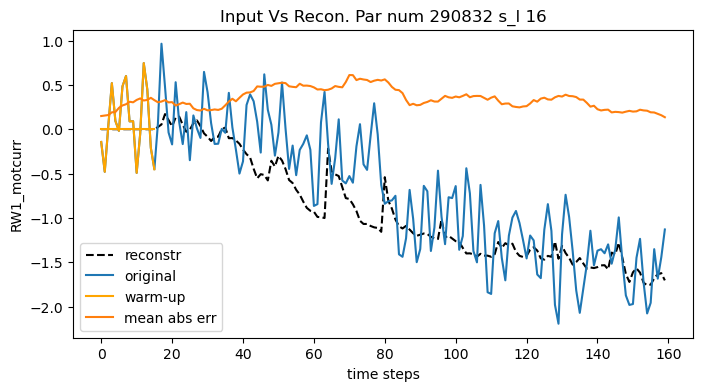

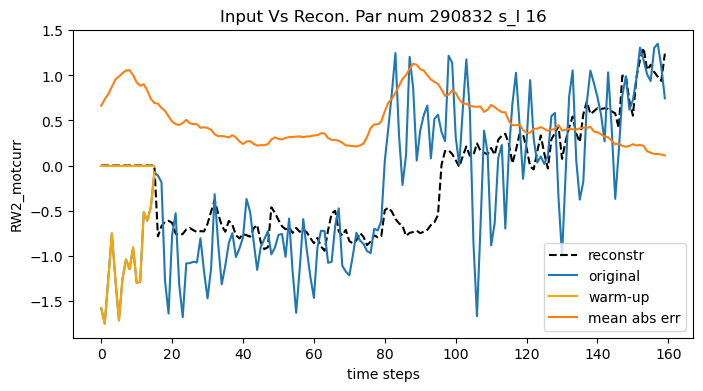

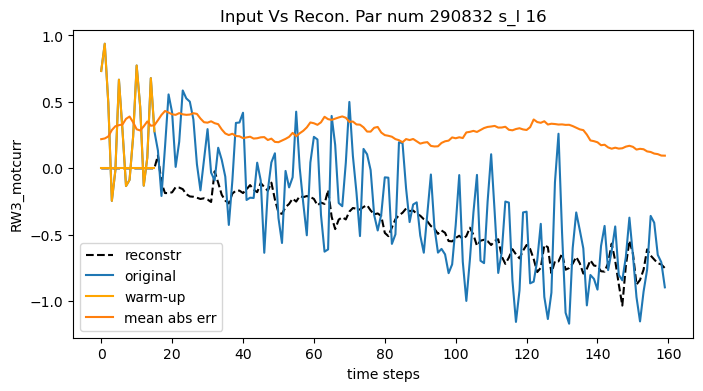

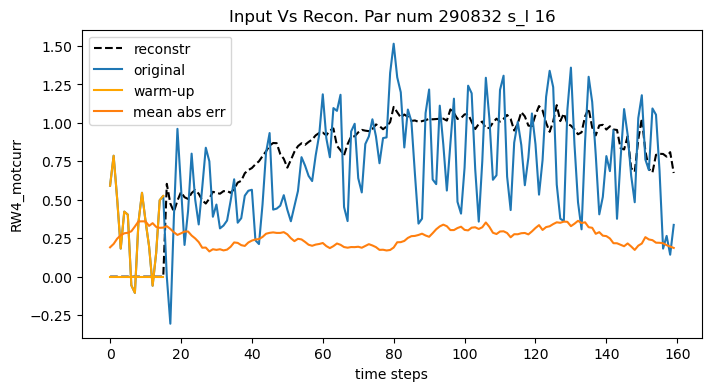

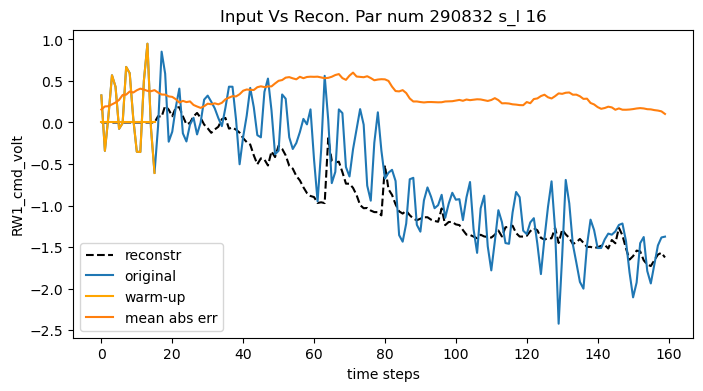

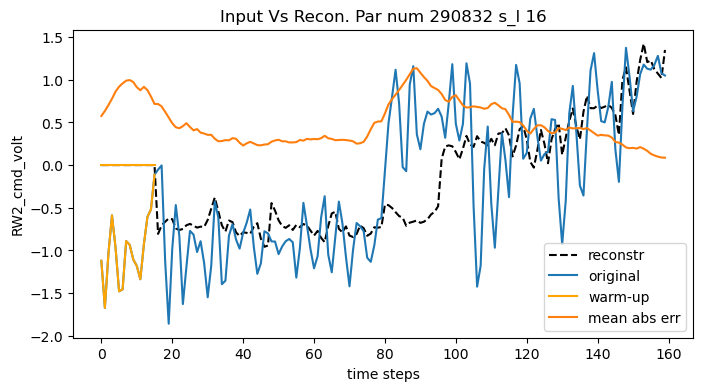

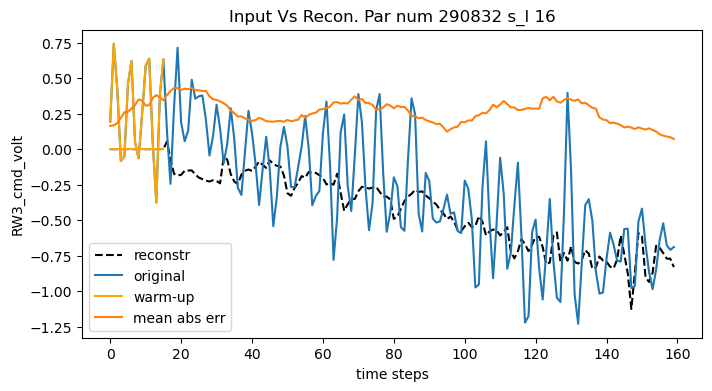

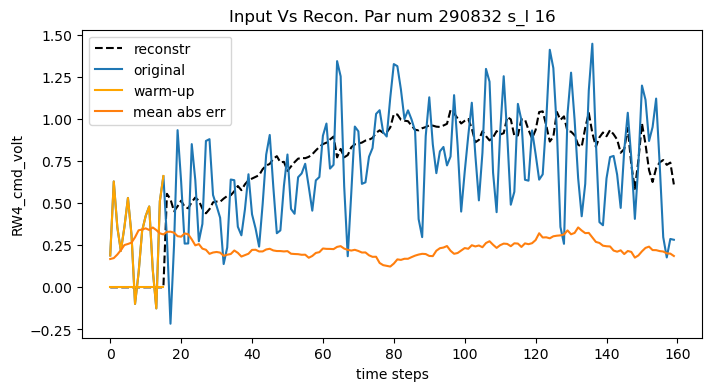

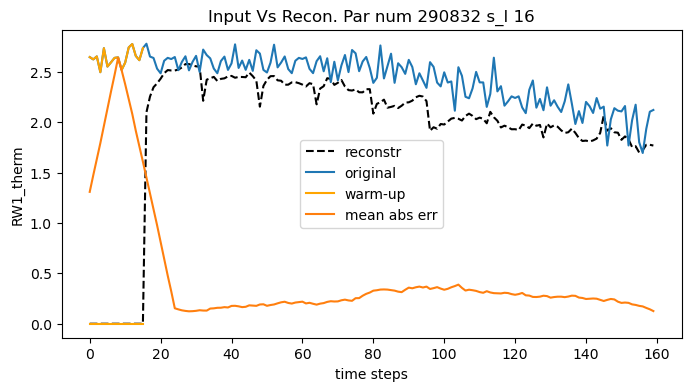

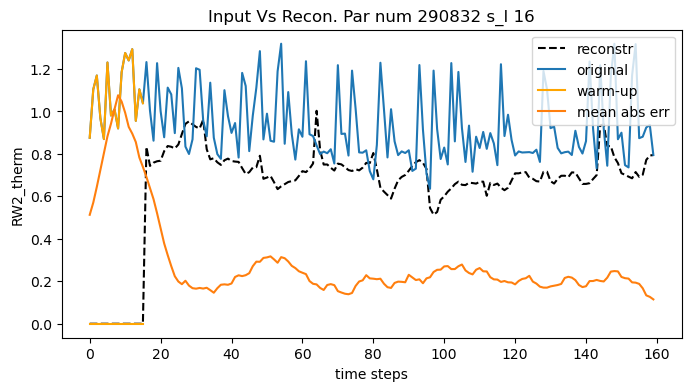

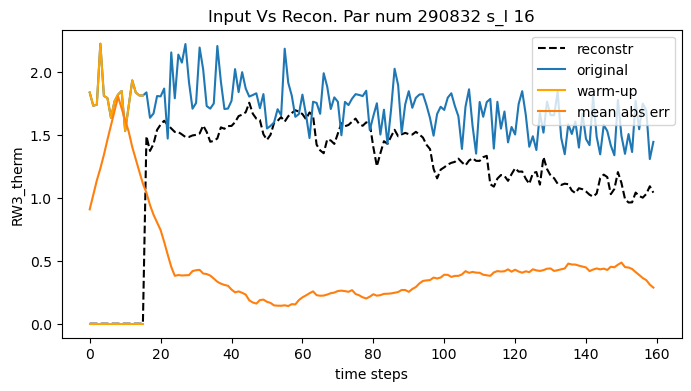

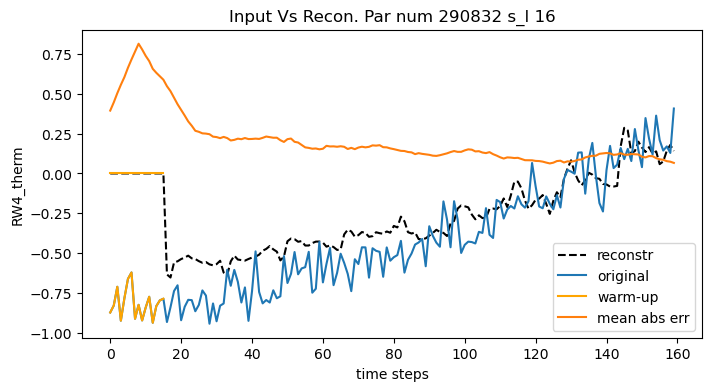

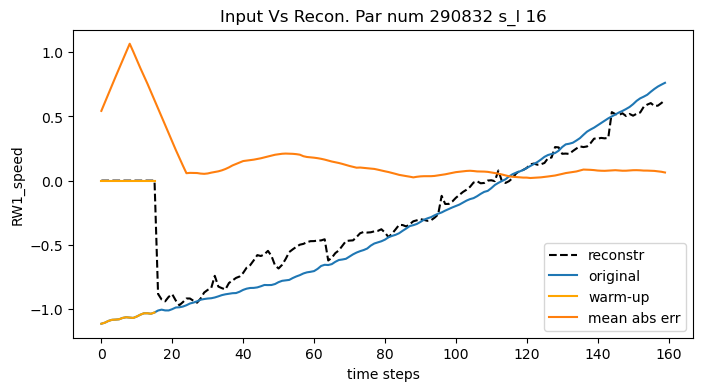

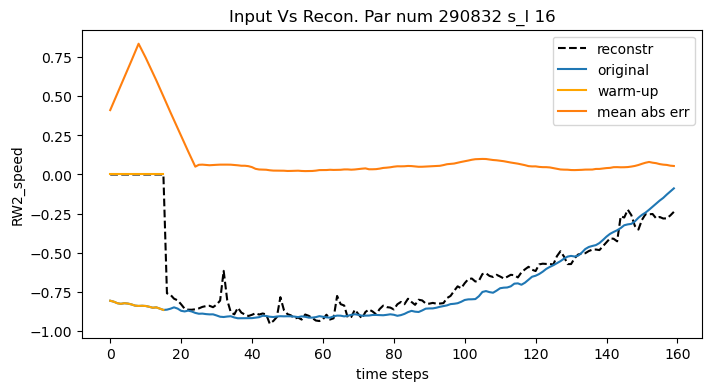

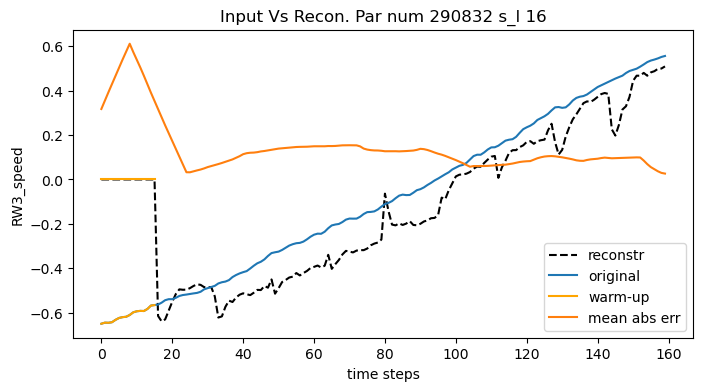

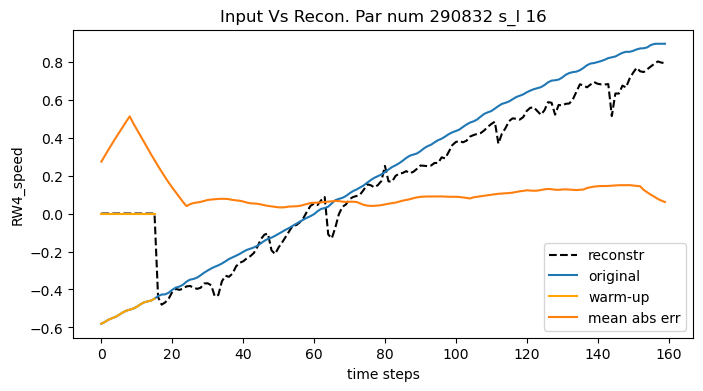

In [21]:
show_results(x.to(device),yo,params_conf['columns'],
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)